In [128]:
from utils import consolidate_deletions_2, remove_reversions, get_parent, nuc_changes_from_ref
from utils_plotting import DateToStr
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, date
import time
import calendar
import math
import json
import string
import requests

## Figure 2 Supplement 1: Ratio of nonsynonymous to synonymous divergence in influenza H3N2 and H1N1pdm

##### The nonsynonymous and synonymous divergence in influenza H3N2 and H1N1pdm HA1 are calculated over time. Accumulation of divergence from the root of the tree is calcuated from phylogenies that start in 2009, when H1N1pdm emerged. The ratio of nonsynonymous to synonymous divergence is then plotted.

#### This notebook completes the analysis Figure 2 Supplement 1. 

Becuase the format of the H3N2 tree and reference file are slightly different than those of SARS-CoV-2, this data will be read in and processed using slightly different functions. Run the following 3 functions, which add node attributes that list the number of synonymous mutations at a node and the number of changes that have accumulated between the root and node

In [60]:
def determine_synonymous_flu(nuc_muts_on_branch, parent_diffs_from_ref, root_json,reference_gene_locations, reference_gene_codon):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            

            # find what gene this mut happens in
            if (mut_pos) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos]
                mut_codon_num = reference_gene_codon[mut_pos][0]
                mut_codon_pos = reference_gene_codon[mut_pos][1]



                # find the root sequence of the codon this mutation occurs in
                # has to be zero-based
                codon_root_aa = root_json[mut_gene][mut_codon_num-1]
                codon_root_nt = root_json['nuc'][(mut_pos-mut_codon_pos-1):(mut_pos-mut_codon_pos+2)]



                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-mut_codon_pos),(mut_pos-mut_codon_pos+3)))

                parent_codon = codon_root_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_root_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()


                codon_mutated = MutableSeq(str(parent_codon))

                
                
                #if deletion (or seq error) has happened at neighboring nucleotide
                if '-' in codon_mutated:
                    pass
                else:
                    codon_mutated[mut_codon_pos] = mut[-1]
                    codon_mutated = codon_mutated.toseq()
                    codon_mutated_translation = codon_mutated.translate()
                    
                    if str(codon_root_aa) == str(codon_mutated_translation):
                        if mut_gene in syn_muts.keys():
                            syn_muts[mut_gene] += [mut]
                        else:
                            syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [149]:
def add_syn_mut_attribute_flu(gene, virus):
    
    # make dictionary giving gene by genomic location 
    reference_gene_locations = {}

    # make dictionary saying what codon within the gene a certain genomic location falls within
    # and whether the mutation is at pos 0, 1 or 2 within codon
    reference_gene_codon = {}
    
    reference_file = f'seasonal-flu_trees/reference_{virus}_{gene}.gb'

        
    for record in SeqIO.parse(open(reference_file,"r"), "genbank"):
        genome_seq = record.seq
        for feature in record.features:
            if feature.type == 'CDS':
                if feature.qualifiers['gene'][0]!='ha':
                    for pos in range(int(feature.location.start)+1, int(feature.location.end)+1):
                        gene_name = feature.qualifiers['gene'][0]
                        reference_gene_locations[pos] = gene_name
                        codon_num = math.floor((pos-feature.location.start+2)/3)
                        pos_in_codon = ((pos-feature.location.start+2)-(codon_num)*3)
                        reference_gene_codon[pos] = (codon_num, pos_in_codon)
    
    if virus in ['h3n2', 'h1n1pdm']:
        with open(f'seasonal-flu_trees/flu_seasonal_{virus}_{gene}_12y_2021-01-11.json') as f:
            tree_json = json.load(f)
        with open(f'seasonal-flu_trees/flu_seasonal_{virus}_{gene}_12y_root-sequence_2021-01-11.json') as f:
            root_json = json.load(f)
    elif virus =='oc43':
        with open(f'seasonal-flu_trees/seasonal_corona_{virus}_a_{gene}_after2009.json') as f:
            tree_json = json.load(f)
        with open(f'seasonal-flu_trees/seasonal_corona_{virus}_a_{gene}_after2009_root-sequence.json') as f:
            root_json = json.load(f)

            
    tree = json_to_tree(tree_json)
    

        
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                parents = get_parent(tree, node)[-1]

                nucleotide_mut_path = []
                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in parents:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_ref(nucleotide_mut_path)


                syn_muts_dict = determine_synonymous_flu(nuc_muts_on_branch, parent_diffs_from_ref, root_json,
                                                     reference_gene_locations, reference_gene_codon)

                node.node_attrs['syn_muts'] = syn_muts_dict
                
    return tree

In [129]:
def add_changes_from_root_attr(gene, virus):
    
    
    tree = add_syn_mut_attribute_flu(gene, virus)
    
    mutations_of_interest = {'ha':'HA1', 'pb1': 'PB1', 's1': 's1'}
    muts_of_interest = mutations_of_interest[gene]
    
    for node in tree.find_clades():


        #Find all parents of the node (includes node too)
        parents = get_parent(tree, node)

        #Find mutations that occur in the parents
        parents_muts = []
        parents_syn = []


        for parent in parents:
            if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
                if muts_of_interest in parent.branch_attrs["mutations"]:
                    parents_muts+=parent.branch_attrs["mutations"][muts_of_interest]

            if hasattr(parent, 'node_attrs') and 'syn_muts' in parent.node_attrs:
                if muts_of_interest in parent.node_attrs['syn_muts']:
                    parents_syn += parent.node_attrs['syn_muts'][muts_of_interest]



        # remove reversion mutations from each list
        parents_muts = remove_reversions(parents_muts)
        parents_syn = remove_reversions(parents_syn)


        # count deletion of adjacent nucleotides as one mutation event
        nonsyn_mutation_list = consolidate_deletions_2(parents_muts)
        syn_mutation_list = consolidate_deletions_2(parents_syn)
        
        dict_key_nonsyn = f'{gene}_non'
        dict_key_syn = f'{gene}_syn'
        node.node_attrs["changes_from_root"] = {dict_key_nonsyn: nonsyn_mutation_list, 
                                          dict_key_syn:syn_mutation_list}
            
    return tree
    

This function generates time windows for the analysis

In [109]:
def make_time_windows(first_timepoint, last_timepoint, window_len):
    """
    Make time windows spanning the duration of time covered by the tree that are of 
    length 'window_len' and overlap by 'window_len/2'
    """
    time_window_starts = np.arange(first_timepoint, last_timepoint, window_len/2).tolist()
    
    time_windows = []
    for s in time_window_starts:
        time_windows.append({'start': s, 'end': s+window_len, 'midpoint': s+window_len/2})
        
    return time_windows

The gene-specific ratios of nonsynonymous to synonymous divergence is calculated here for H3N2 the same way it was calculated for SARS-CoV-2 in Figure 2.

In [142]:
def find_divergence_in_window(viruses = ['h3n2', 'h1n1pdm', 'oc43'], window_len=0.2):
    
    window_dnds_info = []
    
    time_windows = []
    

        
    mutations_of_interest = {'ha':'HA1', 'pb1': 'PB1', 's1':'s1'}
    
    for virus in viruses:
        if virus == 'oc43':
            gene = 's1'
        else:
            gene = 'ha'


        dict_key_nonsyn = f'{gene}_non'
        dict_key_syn = f'{gene}_syn'
        
        if virus in ['h3n2', 'h1n1pdm']:
            with open(f'seasonal-flu_trees/flu_seasonal_{virus}_{gene}_12y_root-sequence_2021-01-11.json') as f:
                root_json = json.load(f)
                gene_length = len(root_json[mutations_of_interest[gene]])
        elif virus == 'oc43':
            with open(f'seasonal-flu_trees/seasonal_corona_{virus}_a_{gene}_after2009_root-sequence.json') as f:
                root_json = json.load(f)
                gene_length = len(root_json[mutations_of_interest[gene]])
            


        tree = add_changes_from_root_attr(gene, virus)

        # want to use the same time windows for both genes, so only make windows for first gene in for loop
        if len(time_windows)==0:
#                 first_timepoint = tree.root.node_attrs['num_date']['value']
            first_timepoint = 2009.0
            last_timepoint = 0
            for node in tree.find_clades():
                if node.node_attrs['num_date']['value'] > last_timepoint:
                    last_timepoint = node.node_attrs['num_date']['value']

            time_windows = make_time_windows(first_timepoint, last_timepoint, window_len)


        # look at divergence within time window
        for x in time_windows:
            start_date = x['start']
            end_date = x['end']

            nonsyn_div_in_window = []
            syn_div_in_window = []

            for node in tree.find_clades():
                if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:

                    if len(node.get_terminals())>=3:

                        nonsyn_div = len(node.node_attrs["changes_from_root"][dict_key_nonsyn])/(gene_length*3*(438/576))

                        #assign a false count to avoid dividing by zero
                        if len(node.node_attrs["changes_from_root"][dict_key_syn]) == 0:
                            syn_div = 1/(gene_length*3*(138/576))
                        else:
                            syn_div = (len(node.node_attrs["changes_from_root"][dict_key_syn])+1)/(gene_length*3*(138/576))


                        n_over_s = nonsyn_div/syn_div



                        window_dnds_info.append({'window_start': start_date, 'window_end': end_date, 
                                                 'window_midpoint': x['midpoint'],
                                                 'dn/ds':n_over_s, 'location': mutations_of_interest[gene], 
                                                 'virus': virus})


        
                

    window_dnds_df = pd.DataFrame(window_dnds_info)
        

    return window_dnds_df
        

Generate the dataframe containing dN/dS information for H3N2 and H1N1pdm HA1 and OC43 S1

In [163]:
window_dnds = find_divergence_in_window(window_len=1.0)

Find the mean dn/ds in HA1

In [175]:
window_dnds[(window_dnds['virus']=='h3n2')&(window_dnds['location']=='HA1')]['dn/ds'].mean()

0.35658183550378136

In [176]:
window_dnds[(window_dnds['virus']=='oc43')&(window_dnds['location']=='s1')]['dn/ds'].mean()

0.48406837797381846

In [177]:
window_dnds[(window_dnds['virus']=='h1n1pdm')&(window_dnds['location']=='HA1')]['dn/ds'].mean()

0.38302760102305516

Now, plot dN/dS in HA1 for H3N2 and H1N1pdm and in S1 for OC43 lineage A over time

This generates Figure 2 Supplement 1.

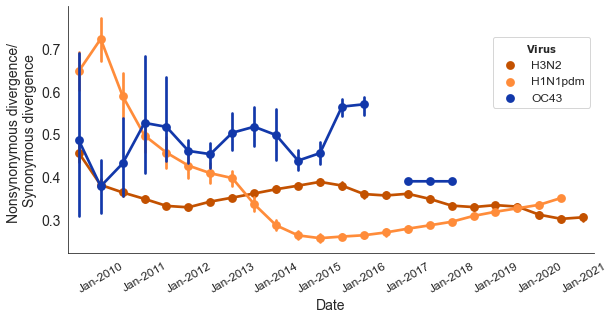

In [179]:
fig, ax = plt.subplots(figsize=(8,4))
plt.tight_layout()
sns.set_style("white")
cmap = {'h1n1pdm':"#ff8c3a", 'h3n2':"#c35100", 'oc43': '#1238aa'}

sns.pointplot(x='window_midpoint', y='dn/ds', hue='virus', palette=cmap,
              data=window_dnds, join=True,
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Nonsynonymous divergence/ \nSynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_xticks([p for p in ax.get_xticks()])
# label with month and year
ax.set_xticklabels(["-".join(DateToStr(float(t.get_text())).split('-')[::2]) for t in ax.get_xticklabels()], rotation=30, size=12)


handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, ['H3N2', 'H1N1pdm', 'OC43'], loc='upper center', bbox_to_anchor=(0.9, 0.9), 
                fontsize=12,
                 title = r'$\bf{Virus}$')

# label every other window midpoint, for better readability
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
fig.savefig('plots/divergence_seasonalflu_and_oc43.png', dpi=300, bbox_inches='tight')



Look at which timepoints H1N1 has an elevated dN/dS ratio

In [178]:
window_dnds[window_dnds['virus']=='h1n1pdm'].groupby('window_midpoint').mean()

,window_start,window_end,dn/ds
window_midpoint,,,
2009.5,2009.0,2010.0,0.647246
2010.0,2009.5,2010.5,0.722976
2010.5,2010.0,2011.0,0.589296
2011.0,2010.5,2011.5,0.496408
2011.5,2011.0,2012.0,0.456364
2012.0,2011.5,2012.5,0.426000
2012.5,2012.0,2013.0,0.408218
2013.0,2012.5,2013.5,0.396696
2013.5,2013.0,2014.0,0.335548
